# Base Model for Client Default Payment Prediction

### Importing libraries

In [97]:
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns 

### Loading data into memory

In [98]:
creditDataPath = "../dataset/default_of_credit_card_clients.csv"
creditData = pd.read_csv(creditDataPath, header = 1, index_col = 0)

### Selecting the dependent and independent variables

In [99]:
creditFeatures = creditData.drop('default payment next month', axis = 1)
creditTarget = creditData.loc[:, 'default payment next month']

### Data sample

In [100]:
#Sampling 10% of the data using the 'train_test_split' method to keep the proportion of the dependent variable.
_, sampleFeatures, _, sampleTarget = train_test_split(creditFeatures, creditTarget, 
                                                       stratify = creditTarget, test_size = 0.1, random_state = 0)

### Split into training and test set

In [101]:
x_train, x_test, y_train, y_test = train_test_split(sampleFeatures, sampleTarget, 
                                                    stratify = sampleTarget, test_size = 0.3, random_state = 0)

### Base Models

In [102]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
svm = SVC(gamma = 'auto')
knn = KNeighborsClassifier()


### Cross-Validation Scores

In [103]:
# Defining function for cross-validation and scores
def cvScores(model, x_train, y_train, cv) :
    modelCVScores = cross_val_score(model, x_train, y_train, cv = cv, n_jobs = -1)
    modelCVScoresMean = modelCVScores.mean()
    modelCVScoresStd = modelCVScores.std()
    
    return pd.DataFrame({'CV-Mean' : [modelCVScoresMean], 'CV-Sd' : [modelCVScoresStd]})

In [104]:
rfCVScore = cvScores(rf, x_train, y_train, 5)
svmCVScore = cvScores(svm, x_train, y_train, 5)
knnCVScore = cvScores(knn, x_train, y_train, 5)

In [105]:
print('Random Forest')
print(rfCVScore)

print('\nSVM')
print(svmCVScore)

print('\nK-NN')
print(knnCVScore)

Random Forest
   CV-Mean     CV-Sd
0  0.79381  0.012103

SVM
    CV-Mean     CV-Sd
0  0.777143  0.002857

K-NN
   CV-Mean     CV-Sd
0     0.74  0.020504


### Predictions and metrics

In [106]:
# Defining function for prediction and metrics
def classif_predict_metric(model, x_test, y_test) :
    modelPredictions = model.predict(x_test)

    accuracy_model = accuracy_score(y_test, modelPredictions)
    kappa_model = cohen_kappa_score(y_test, modelPredictions)
    
    return modelPredictions, accuracy_model, kappa_model

In [107]:
# Fitting models
rf = rf.fit(x_train, y_train)
svm = svm.fit(x_train, y_train)
knn = knn.fit(x_train, y_train)

In [108]:
rfPrediction, accuracy_rf, kappa_rf = classif_predict_metric(rf, x_test, y_test)
print('Random Forest accuracy: %.6f' % accuracy_rf)
print('Random Forest kappa: %.6f' % kappa_rf)

svmPrediction, accuracy_svm, kappa_svm = classif_predict_metric(svm, x_test, y_test)
print('\nSVM accuracy: %.6f' % accuracy_svm)
print('SVM kappa: %.6f' % kappa_svm)

knnPrediction, accuracy_knn, kappa_knn = classif_predict_metric(knn, x_test, y_test)
print('\nK-NN accuracy: %.6f' % accuracy_knn)
print('K-NN kappa: %.6f' % kappa_knn)

Random Forest accuracy: 0.806667
Random Forest kappa: 0.324447

SVM accuracy: 0.775556
SVM kappa: -0.006611

K-NN accuracy: 0.763333
K-NN kappa: 0.149074


### Variables Importance

In [127]:
var_imp = pd.DataFrame({'Variable' : creditData.drop('default payment next month', axis = 1).columns, 
                        'Score' : rf.feature_importances_})

var_imp.sort_values('Score', ascending = False)

,Variable,Score
5,PAY_0,0.098717
4,AGE,0.060960
12,BILL_AMT2,0.056006
15,BILL_AMT5,0.055475
11,BILL_AMT1,0.053959
14,BILL_AMT4,0.053101
0,LIMIT_BAL,0.052142
17,PAY_AMT1,0.050601
18,PAY_AMT2,0.050599
13,BILL_AMT3,0.050546


## Feature Selection

In [110]:
x_train_fs = x_train
x_test_fs = x_test

# Removing variables with high colinearity
x_train_fs = x_train_fs.drop(['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis = 1)
x_test_fs = x_test_fs.drop(['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis = 1)

# Removing variables least important
x_train_fs = x_train_fs.drop(['SEX', 'MARRIAGE', 'EDUCATION', 'PAY_6', 'PAY_5', 'PAY_4', 'PAY_3'], axis = 1)
x_test_fs = x_test_fs.drop(['SEX', 'MARRIAGE', 'EDUCATION', 'PAY_6', 'PAY_5', 'PAY_4', 'PAY_3'], axis = 1)

x_train_fs.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'BILL_AMT1', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

### Model

In [111]:
# Initializing Models
rf_fs = RandomForestClassifier(n_estimators = 10, random_state = 0, n_jobs = -1)
svm_fs = SVC(gamma = 'auto')
knn_fs = KNeighborsClassifier(n_jobs = -1)

### Cross-validation

In [112]:
rf_fs_CVScore = cvScores(rf_fs, x_train_fs, y_train, 5)
svm_fs_CVScore = cvScores(svm_fs, x_train_fs, y_train, 5)
knn_fs_CVScore = cvScores(knn_fs, x_train_fs, y_train, 5)

In [113]:
print('Random Forest')
print(rf_fs_CVScore)

print('\nSVM')
print(svm_fs_CVScore)

print('\nK-NN')
print(knn_fs_CVScore)

Random Forest
    CV-Mean     CV-Sd
0  0.799048  0.006999

SVM
    CV-Mean     CV-Sd
0  0.777619  0.001905

K-NN
    CV-Mean     CV-Sd
0  0.750476  0.007882


### Predictions and metrics

In [114]:
# Fitting models
rf_fs = rf_fs.fit(x_train_fs, y_train)
svm_fs = svm_fs.fit(x_train_fs, y_train)
knn_fs = knn_fs.fit(x_train_fs, y_train)

In [115]:
rf_fs_Prediction, accuracy_rf_fs, kappa_rf_fs = classif_predict_metric(rf_fs, x_test_fs, y_test)
print('Random Forest accuracy: %.6f' % accuracy_rf_fs)
print('Random Forest kappa: %.6f' % kappa_rf_fs)

svm_fs_Prediction, accuracy_svm_fs, kappa_svm_fs = classif_predict_metric(svm_fs, x_test_fs, y_test)
print('\nSVM accuracy: %.6f' % accuracy_svm_fs)
print('SVM kappa: %.6f' % kappa_svm_fs)

knn_fs_Prediction, accuracy_knn_fs, kappa_knn_fs = classif_predict_metric(knn_fs, x_test_fs, y_test)
print('\nK-NN accuracy: %.6f' % accuracy_knn_fs)
print('K-NN kappa: %.6f' % kappa_knn_fs)

Random Forest accuracy: 0.794444
Random Forest kappa: 0.273877

SVM accuracy: 0.776667
SVM kappa: -0.004420

K-NN accuracy: 0.743333
K-NN kappa: 0.051811


## Hyperparameters Tuning

In [116]:
# Standardization of data
scaler = preprocessing.StandardScaler().fit(x_train_fs)

x_train_fs_std = scaler.transform(x_train_fs)
x_test_fs_std = scaler.transform(x_test_fs)

## Random Forest

### Random Search

In [117]:
rf_params = {'n_estimators' : np.arange(100, 2000, 100), 
            'max_features' : np.arange(1, len(x_train_fs.columns), 1), 
            'max_depth' : np.arange(1, 25, 1)}
rf_default = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf_default, 
                               param_distributions = rf_params, 
                               n_iter = 100, 
                               cv = 3, verbose = 2, random_state = 0, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_fs, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


{'n_estimators': 300, 'max_features': 7, 'max_depth': 3}

#### Cross-Validation Scores

In [118]:
# rf_hyp = RandomForestClassifier(n_estimators = 1700, max_features = 2, max_depth = 16, n_jobs = -1)
rf_hyp = RandomForestClassifier(n_estimators = 300, max_features = 7, max_depth = 3, n_jobs = -1)

In [121]:
rf_hyp_CVScores = cvScores(rf_hyp, x_train_fs, y_train, cv = 5)

In [122]:
print('Random Forest')
print(rf_hyp_CVScores)

Random Forest
   CV-Mean     CV-Sd
0     0.81  0.012724


#### Predictions and metrics

In [123]:
# Fitting model
rf_hyp = rf_hyp.fit(x_train_fs, y_train)

In [124]:
rf_hyp_pred = rf_hyp.predict(x_test_fs)

accuracy_rf_hyp = accuracy_score(y_test, rf_hyp_pred)
kappa_rf_hyp = cohen_kappa_score(y_test, rf_hyp_pred)

print("Random Forest Accuracy Score: %.6f" % accuracy_rf_hyp)
print("Random Forest Kappa Score: %.6f \n" % kappa_rf_hyp)

Random Forest Accuracy Score: 0.832222
Random Forest Kappa Score: 0.402091 



In [128]:
var_imp_hyp = pd.DataFrame({'Variable' : x_train_fs.columns, 
                        'Score' : rf_hyp.feature_importances_})

var_imp_hyp.sort_values('Score', ascending = False)

,Variable,Score
2,PAY_0,0.526996
3,PAY_2,0.244777
6,PAY_AMT2,0.045360
8,PAY_AMT4,0.043537
4,BILL_AMT1,0.033556
5,PAY_AMT1,0.032326
0,LIMIT_BAL,0.022564
9,PAY_AMT5,0.015308
10,PAY_AMT6,0.013366
7,PAY_AMT3,0.011845


### Grid Search

In [129]:
# rf_params = {'n_estimators' : np.arange(1600, 1850, 50), 
#             'max_features' : np.arange(1, 6, 1), 
#             'max_depth' : np.arange(14, 19, 1)}
# rf_default = RandomForestClassifier(random_state = 0)

# rf_grid = GridSearchCV(estimator = rf_default, 
#                        param_grid = rf_params, 
#                        cv = 3, verbose = 2, n_jobs = -1)
# # Fit the random search model
# rf_grid = rf_grid.fit(x_train_fs, y_train)

rf_params = {'n_estimators' : np.arange(200, 400, 25), 
            'max_features' : np.arange(2, 11, 1), 
            'max_depth' : np.arange(1, 16, 1)}
rf_default = RandomForestClassifier(random_state = 0)

rf_grid = GridSearchCV(estimator = rf_default, 
                       param_grid = rf_params, 
                       cv = 3, verbose = 2, n_jobs = -1)
# Fit the random search model
rf_grid = rf_grid.fit(x_train_fs, y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 23.6min finished


In [130]:
rf_grid.best_params_

{'max_depth': 2, 'max_features': 8, 'n_estimators': 200}

#### Cross-validation Scores

In [131]:
# rf_hyp = RandomForestClassifier(n_estimators = 1750, max_features = 6, max_depth = 16, n_jobs = -1)

rf_hyp = RandomForestClassifier(n_estimators = 200, max_features = 8, max_depth = 2, n_jobs = -1)

In [132]:
rf_hyp_CVScores = cvScores(rf_hyp, x_train_fs, y_train, cv = 5)

In [133]:
print('Random Forest')
print(rf_hyp_CVScores)

Random Forest
    CV-Mean     CV-Sd
0  0.808095  0.010605


#### Predictions and metrics

In [134]:
# Fitting model
rf_hyp = rf_hyp.fit(x_train_fs, y_train)

In [135]:
rf_hyp_pred, accuracy_rf_hyp, kappa_rf_hyp = classif_predict_metric(rf_hyp, x_test_fs, y_test)

print("Random Forest Accuracy Score: %.6f" % accuracy_rf_hyp)
print("Random Forest Kappa Score: %.6f \n" % kappa_rf_hyp)

Random Forest Accuracy Score: 0.832222
Random Forest Kappa Score: 0.402091 



## SVM

### Random Search

In [150]:
svm_params = {'gamma' : list(10.0**exp for exp in np.arange(-80, -49, 1)), 
            'C' : [3, 4, 5, 6, 7], 
            'kernel' : ['linear']}
svm_default = SVC(gamma = 'auto', random_state = 0)

svm_random = RandomizedSearchCV(estimator = svm_default, 
                               param_distributions = svm_params, 
                               n_iter = 100, 
                               cv = 3, verbose = 2, random_state = 0, n_jobs = -1)
# Fit the random search model
svm_random.fit(x_train_fs_std, y_train)
svm_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


{'kernel': 'linear', 'gamma': 1e-52, 'C': 5}

#### Cross-validation Scores

In [89]:
svm_hyp = SVC(gamma = 1e-52, C = 5, kernel = 'linear')

In [90]:
svm_hyp_CVScores = cvScores(svm_hyp, x_train_fs_std, y_train, cv = 5)

In [91]:
print('SVM')
print(svm_hyp_CVScores)

SVM
   CV-Mean    CV-Sd
0  0.80619  0.01612


#### Predictions and Metrics

In [92]:
# Fitting model
svm_hyp = svm_hyp.fit(x_train_fs_std, y_train)

In [93]:
svm_hyp_pred, accuracy_svm_hyp, kappa_svm_hyp = classif_predict_metric(svm_hyp, x_test_fs_std, y_test)

print("SVM Accuracy Score: %.6f" % accuracy_svm_hyp)
print("SVM Kappa Score: %.6f \n" % kappa_svm_hyp)

SVM Accuracy Score: 0.801111
SVM Kappa Score: 0.261876 



## K-NN

### Random Search

In [136]:
knn_params = {'n_neighbors' : np.arange(3, 53, 2), 
            'weights' : ['uniform', 'distance'], 
            'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
knn_default = KNeighborsClassifier()

knn_random = RandomizedSearchCV(estimator = knn_default, 
                               param_distributions = knn_params, 
                               n_iter = 100, 
                               cv = 3, verbose = 2, random_state = 0, n_jobs = -1)
# Fit the random search model
knn_random.fit(x_train_fs_std, y_train)
knn_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.1s finished


{'weights': 'uniform', 'n_neighbors': 35, 'algorithm': 'brute'}

#### Cross-validation Scores

In [137]:
knn_hyp = KNeighborsClassifier(n_neighbors = 35, weights = 'uniform', algorithm = 'brute', n_jobs = -1)

In [138]:
knn_hyp_CVScores = cvScores(knn_hyp, x_train_fs_std, y_train, cv = 5)

In [139]:
print('K-NN')
print(knn_hyp_CVScores)

K-NN
    CV-Mean    CV-Sd
0  0.815714  0.01633


#### Predictions and Metrics

In [140]:
# Fitting model
knn_hyp = knn_hyp.fit(x_train_fs_std, y_train)

In [141]:
knn_hyp_pred, accuracy_knn_hyp, kappa_knn_hyp = classif_predict_metric(knn_hyp, x_test_fs_std, y_test)

print("Random Forest Accuracy Score: %.6f" % accuracy_knn_hyp)
print("Random Forest Kappa Score: %.6f \n" % kappa_knn_hyp)

Random Forest Accuracy Score: 0.822222
Random Forest Kappa Score: 0.370624 



### Grid Search

In [143]:
knn_params = {'n_neighbors' : np.arange(15, 47, 2), 
            'weights' : ['uniform', 'distance'], 
            'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
knn_default = KNeighborsClassifier()

knn_grid = GridSearchCV(estimator = knn_default, 
                          param_grid = knn_params, 
                          cv = 3, verbose = 2, n_jobs = -1)
# Fit the random search model
knn_grid.fit(x_train_fs_std, y_train)
knn_grid.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    7.5s finished


{'algorithm': 'ball_tree', 'n_neighbors': 33, 'weights': 'uniform'}

#### Cross-validation Scores

In [144]:
knn_hyp = KNeighborsClassifier(n_neighbors = 33, weights = 'uniform', algorithm = 'ball_tree', n_jobs = -1)

In [145]:
knn_hyp_CVScores = cvScores(knn_hyp, x_train_fs_std, y_train, cv = 5)

In [146]:
print('K-NN')
print(knn_hyp_CVScores)

K-NN
    CV-Mean    CV-Sd
0  0.814762  0.01693


#### Predictions and metrics

In [147]:
# Fitting model
knn_hyp = knn_hyp.fit(x_train_fs_std, y_train)

In [148]:
knn_hyp_pred, accuracy_knn_hyp, kappa_knn_hyp = classif_predict_metric(knn_hyp, x_test_fs_std, y_test)

print("Random Forest Accuracy Score: %.6f" % accuracy_knn_hyp)
print("Random Forest Kappa Score: %.6f \n" % kappa_knn_hyp)

Random Forest Accuracy Score: 0.821111
Random Forest Kappa Score: 0.368077 



## Results

### Accuracy and Kappa

In [149]:
accuracy = [accuracy_rf_hyp, accuracy_svm_hyp, accuracy_knn_hyp]
kappa = [kappa_rf_hyp, kappa_svm_hyp, kappa_knn_hyp]
algorithm = ['Random Forest', 'SVM', 'K-NN']

results = pd.DataFrame({'Accuracy' : accuracy, 'Kappa' : kappa}, index = algorithm)
results

,Accuracy,Kappa
Random Forest,0.832222,0.402091
SVM,0.801111,0.261876
K-NN,0.821111,0.368077


### Confusion Matrix

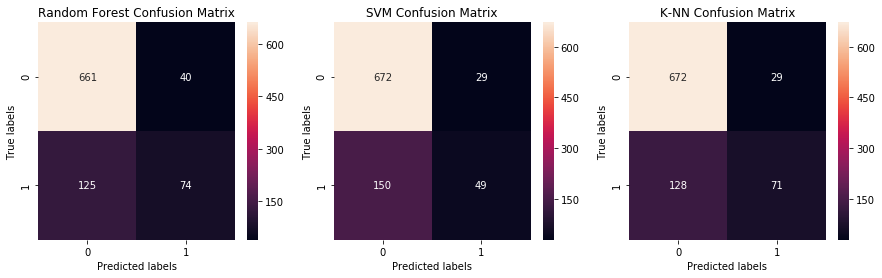

In [96]:
confusionMatrix_rf = confusion_matrix(y_test, rf_hyp_pred)
confusionMatrix_svm = confusion_matrix(y_test, svm_hyp_pred)
confusionMatrix_knn = confusion_matrix(y_test, knn_hyp_pred)

fig, ax = plt.subplots(1, 3)

# labels, title and ticks
sns.heatmap(confusionMatrix_rf, annot = True, ax = ax[0], fmt = 'g');
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Random Forest Confusion Matrix');

sns.heatmap(confusionMatrix_svm, annot = True, ax = ax[1], fmt = 'g');
ax[1].set_xlabel('Predicted labels');
ax[1].set_ylabel('True labels'); 
ax[1].set_title('SVM Confusion Matrix');

sns.heatmap(confusionMatrix_knn, annot = True, ax = ax[2], fmt = 'g');
ax[2].set_xlabel('Predicted labels');
ax[2].set_ylabel('True labels'); 
ax[2].set_title('K-NN Confusion Matrix');

fig.set_figwidth(15)

plt.subplots_adjust(wspace = 0.2)
plt.show()